<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Addressing Overfitting

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
%matplotlib inline

Increasing model complexity can decrease bias but will eventually lead to overfitting. This lesson is about what to do when your model is overfitting.

## Getting More Data

Getting more data is the surest way to reduce overfitting.

In [3]:
ames_df = pd.read_csv('../assets/data/ames_train.csv')
# Dropping `OverallQual` because it is not always available
ames_df = ames_df.drop(['Id', 'OverallQual'], axis='columns')

In [4]:
ames_df.shape

(1460, 79)

In [5]:
ames_df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
# Make a function to calculate training score on the whole dataset
# and cross-validated test score.
# /scrub/
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold

def my_cv_score(estimator, X, y, n_splits=10):
    estimator.fit(X, y)
    train_score = estimator.score(X, y)
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    test_score = cross_val_score(estimator, X, y, cv=kf).mean()
                          
    return train_score, test_score

In [7]:
# Use 5-fold cross-validation to calculate training-set and test-set scores using 200 rows of data
# /scrub/
ames_df_num = ames_df.select_dtypes(['int64', 'float64']).dropna(axis='columns')
ames_small = ames_df_num.sample(100, random_state=42)

X_small = ames_small.drop('SalePrice', axis='columns')
y_small = ames_small.loc[:, 'SalePrice']

linreg = LinearRegression()
my_cv_score(linreg, X_small, y_small)

(0.8958123466965703, 0.605448662142623)

In [8]:
# Use 5-fold cross-validation to calculate training-set and test-set scores using all the data
# /scrub/
X = ames_df_num.drop('SalePrice', axis='columns')
y = ames_df.loc[:, 'SalePrice']

my_cv_score(linreg, X, y)

(0.7788559155673486, 0.7307411610581306)

**When collecting more data is not too expensive, it should be your first resort to address overfitting.**

**Exercise (1 min.)**

- How does getting more rows of data affect a given model type's bias and variance?

/scrub/

Has no effect on bias, decreases variance.

## Feature Selection

### Why Select Features?

Often it is best not to use all of your features, for at least two reasons:

1. Using more features makes your model harder to interpret.
2. Removing features may improve overall predictive performance by reducing overfitting.

These problems become particularly acute when you start using feature engineering to generate derived features.

### Adding Features in Order of Importance

Here is one recipe for optimizing a model through feature selection:

1. Rank features according to some measure of importance *calculated on the training set*.
2. Add features to your model in the order given by that ranking, fitting on the training set and measuring predictive performance on the test set each time.
3. Choose the set of features that gives the best predictive performance.

It is inappropriate to use the test set in your calculation of feature importance because you will not have the benefit of information about feature importance for the data the model sees when you deploy it.

When using cross-validation, you need to calculate your measure of importance on the training set *for each fold*. With this approach, you can have different features in your model for different folds. You should think of cross-validation in this case as estimating the performance of your entire *model-generating procedure*, rather than the particular model that it produces.

#### Example: Using Random Forest Feature Importances

Here we will fit a random forest and use the feature importances as our measure of predictive value.

Calculating random forest feature importances is computationally expensive, so we want to do it once for each fold, rather than once for each fold and each number of features.

**Warning:** the code is about to get a little complicated.

In [9]:
# Make a function to calculate cross-validation scores by number of features
# /scrub/
def my_cv_score_by_num_features(estimator, X, y, rank_features_func, n_splits=10):
    train_scores = []
    test_scores = []

    kf = KFold(n_splits=n_splits, shuffle=True)
    for train_rows, test_rows in tqdm(kf.split(X, y), total=n_splits):
        X_train = X.iloc[train_rows, :]
        X_test = X.iloc[test_rows, :]
        y_train = y.iloc[train_rows]
        y_test = y.iloc[test_rows]

        ranked_features = rank_features_func(X_train, y_train)

        train_scores_fold = []
        test_scores_fold = []
        for num_features in range(1, len(ranked_features) + 1):
            feature_cols = ranked_features[:num_features]
            X_train_k = X_train.loc[:, feature_cols]
            X_test_k = X_test.loc[:, feature_cols]

            linreg.fit(X_train_k, y_train)
            train_scores_fold.append(linreg.score(X_train_k, y_train))
            test_scores_fold.append(linreg.score(X_test_k, y_test))

        train_scores.append(train_scores_fold)
        test_scores.append(test_scores_fold)

    train_scores = np.array(train_scores).T.mean(axis=1)
    test_scores = np.array(test_scores).T.mean(axis=1)
    return pd.DataFrame({'num_features': range(1, len(ranked_features) + 1),
                         'train': train_scores, 'test': test_scores
                        })

In [10]:
# Make a function to rank features according to estimator feature importances
# /scrub/
def rank_features_by_estimator_importances(X, y, estimator):
    estimator.fit(X, y)
    feature_ranks_worst_first = estimator.feature_importances_.argsort()
    ranked_features = X.columns[feature_ranks_worst_first][::-1]
    return ranked_features

In [11]:
# Create a more specialized function to rank features according to random
# forest regressor feature importances
# /scrub/
from functools import partial
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(100)
rank_features_by_rfr_importances = partial(rank_features_by_estimator_importances, estimator=rfr)

In [12]:
# Get scores by number of features for a linear regression model
# on our sampled Ames dataset, adding features in order of
# decreasing random forest regressor importances.
# /scrub/
scores = my_cv_score_by_num_features(
    linreg, X_small, y_small, rank_features_by_rfr_importances
)

100%|██████████| 10/10 [00:01<00:00,  5.36it/s]


In [13]:
# Look at the scores
# /scrub/
scores

,num_features,train,test
0,1,0.572174,0.506557
1,2,0.681509,0.556319
2,3,0.747117,0.600645
3,4,0.782508,0.663093
4,5,0.806910,0.683064
5,6,0.817011,0.697747
6,7,0.832462,0.700876
7,8,0.837077,0.721728
8,9,0.849272,0.757512
9,10,0.857819,0.741653


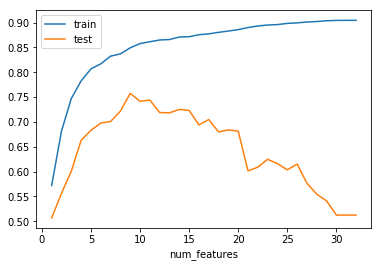

In [14]:
# Plot scores
# /scrub/
ax = scores.plot(x='num_features')

In [15]:
# Look at scores in descending order, identify
# the number of features that worked best.
# /scrub/
scores.sort_values('test', ascending=False)

,num_features,train,test
8,9,0.849272,0.757512
10,11,0.861460,0.744073
9,10,0.857819,0.741653
13,14,0.871011,0.725172
14,15,0.871684,0.723118
7,8,0.837077,0.721728
11,12,0.865050,0.718948
12,13,0.865974,0.718358
16,17,0.877367,0.704875
6,7,0.832462,0.700876


See scikit-learn's [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) for some alernatives to random forest feature importances.

#### Limitations of Adding Features in Order of Importance

##### Result May Not Be Optimal

Picking an "all-star team" of features based on their individual performances can miss combinations of features that work better overall because they complement each other well.

For instance, if you had temperature in Celsius and temperature in Fahrenheit in your data set and used correlation with the target as your measure of importance, this approach would use both of those features without regard for the fact that they are redundant. Using random forest feature importances addresses this problem to some extent.

##### Can Be Slow

This approach requires fitting many times, so it can be quite slow, especially when you combine it with ensembling and cross-validation.

### Alternative Approaches to Feature Selection

- Start with all of the features and gradually remove them.
- Add/remove one feature at a time, each time testing how much the change helps or hurts. Choose the feature that helps the most at each stage, stopping when you cannot find one that helps substantially.
- Choose the top $k$ features based on a measure of feature importance without fitting a model on each set of features.
- Try all combinations of features. (This approach quickly becomes computationally infeasible.)
- Try random combinations of features.

**Exercise (12 mins., in pairs)**

There is some randomness in the processes used in this exercise, so we will not all get the same answers.

- How does dropping a feature typically affect a model's bias and variance?

/scrub/

Increases bias, decreases variance.

Stricly: it can either increase bias or leave bias unchanged, and it can increase variance if the feature is highly informative.

- Create a feature matrix `X` and a target series `y` for the Titanic dataset (located in this lesson's  `assets/data` directory). Drop "PassengerId", "Name", and "Ticket." Dummy-code string columns as needed. Impute missing values using a median.

In [16]:
# /scrub/
titanic = pd.read_csv('../assets/data/titanic.csv')

In [17]:
# /scrub/
titanic = titanic.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis='columns')

In [18]:
# /scrub/
titanic_dummies = pd.get_dummies(titanic, columns=['Sex', 'Embarked'], drop_first=True)

In [19]:
# /scrub/
X = titanic_dummies.drop('Survived', axis='columns')
y = titanic_dummies.loc[:, 'Survived']

In [20]:
# /scrub/
X.loc[:, 'Age'] = X.loc[:, 'Age'].fillna(X.loc[:, 'Age'].median())

In [21]:
# Run this cell to check your work
assert X.shape == (891, 8)
assert y.shape == (891,)

- We are going to use random forest feature importances for the Titanic dataset. What would be wrong with using a `RandomForestRegressor` for this purpose? What should we use instead? (Hint: we use this dataset for classification.)

A `RandomForestRegressor` would be inappropriate for this problem because it does regression rather than classification. We should use a `RandomForestClassifier` instead.

- Create a function analogous to `rank_features_by_rfr_importances` that uses a `RandomForestClassifier` in place of a `RandomForestRegressor`.

In [22]:
# /scrub/
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(100)
rank_features_by_rfc_importances = partial(rank_features_by_estimator_importances, estimator=rfc)

- Use `my_cv_score_by_num_features` to calculate training and cross-validation scores for a logistic regression model on the Titanic dataset by number of features, adding features in order of increasing `RandomForestClassifier` feature importance. Call your logistic regression estimator `logreg`.

In [23]:
# /scrub/
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
scores = my_cv_score_by_num_features(logreg, X, y, rank_features_func=rank_features_by_rfc_importances)

100%|██████████| 10/10 [00:01<00:00,  7.88it/s]


- Plot the scores by number of features.

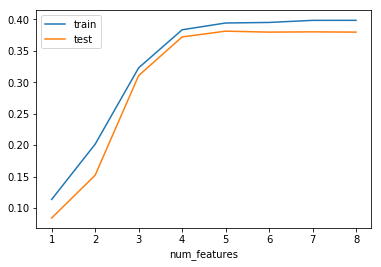

In [24]:
# /scrub/
ax = scores.plot(x='num_features')

- Identify the number of features that gave the best score.

In [25]:
# /scrub/
scores.sort_values('test', ascending=False).head(1).loc[:, 'num_features']

4    5
Name: num_features, dtype: int64

- **Bonus:** Calculate the training and test-set scores without using `my_cv_score_by_num_features`

In [26]:
# /scrub/
rfc = RandomForestClassifier()

train_scores = []
test_scores = []

kf = KFold(n_splits=10, shuffle=True)
for train_rows, test_rows in tqdm(kf.split(X, y), total=10):
    X_train = X.iloc[train_rows, :]
    X_test = X.iloc[test_rows, :]
    y_train = y.iloc[train_rows]
    y_test = y.iloc[test_rows]

    model = rfc.fit(X_train, y_train)
    importances = rfc.feature_importances_
    feature_ranks_worst_first = rfc.feature_importances_.argsort()
    ranked_features = X.columns[feature_ranks_worst_first][::-1]

    train_scores_fold = []
    test_scores_fold = []
    for num_features in range(1, len(ranked_features) + 1):
        feature_cols = ranked_features[:num_features]
        X_train_k = X_train.loc[:, feature_cols]
        X_test_k = X_test.loc[:, feature_cols]

        linreg.fit(X_train_k, y_train)
        train_scores_fold.append(linreg.score(X_train_k, y_train))
        test_scores_fold.append(linreg.score(X_test_k, y_test))

    train_scores.append(train_scores_fold)
    test_scores.append(test_scores_fold)

train_scores = np.array(train_scores).T.mean(axis=1)
test_scores = np.array(test_scores).T.mean(axis=1)
scores = pd.DataFrame({'num_features': range(1, len(ranked_features) + 1),
                       'train': train_scores, 'test': test_scores
                      })

  0%|          | 0/10 [00:00<?, ?it/s]/Users/gGandenberger/anaconda3/envs/ga/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
100%|██████████| 10/10 [00:00<00:00, 24.19it/s]


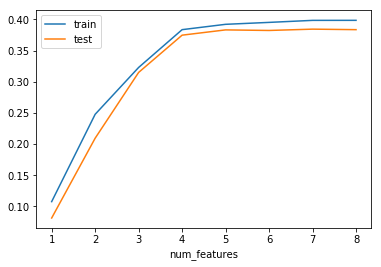

In [27]:
# /scrub/
ax = scores.plot(x='num_features')

$\blacksquare$

## Dimensionality Reduction with PCA

Feature selection is a kind of dimensionality reduction: every time we drop a feature, we reduce the number of dimensions in the feature space by 1.

Special dimensionality reduction techniques allow us to reduce the dimensionality of the feature space in a way that **preserves more information** than simply dropping features.

For instance, **Principle Component Analysis** finds the "most informative" *combinations of features* before dropping some of those combinations.

[Visual explanation of PCA](http://setosa.io/ev/principal-component-analysis/)

### Example: PCA on Temp, Atemp

In [28]:
bikes = pd.read_csv('../assets/data/bikeshare.csv')

"atemp" and "temp" lie almost on a line, with "atemp" departing from temp based on factors such as wind and humidity.

PCA returns that line as its first principal component and departures from that line as its second principal component.

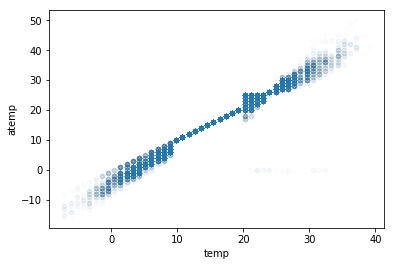

In [29]:
# Plot atemp against temp
# /scrub/
ax = bikes.plot(kind='scatter', x='temp', y='atemp', alpha=.01)

In [30]:
# Inspect the anomalous points with atemp nearly zero but temp > 20
# /scrub/
anomalies = bikes.loc[abs(bikes.loc[:, 'atemp']) < .01, ['temp', 'atemp']]
anomalies

,temp,atemp
59,4.22,-0.0016
60,4.22,-0.0016
61,4.22,-0.0016
109,3.28,-0.0016
115,0.46,-0.0016
123,0.46,-0.0016
163,0.46,-0.0016
315,3.28,-0.0016
316,2.34,-0.0016
320,0.46,-0.0016


In [31]:
# Look closer at the "atemp" values
# /scrub/
anomalies.loc[:, 'atemp'].value_counts()

-0.0016    293
Name: atemp, dtype: int64

In [32]:
# Filer out the anomalous rows
# /scrub/
bikes = bikes.loc[bikes.loc[:, 'atemp'] != -.0016, :]

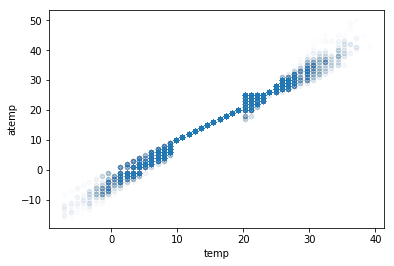

In [33]:
# Make a plot to confirm that we removed the anomalous points
# /scrub/
ax = bikes.plot(kind='scatter', x='temp', y='atemp', alpha=.01)

In [34]:
# Instantiate a PCA transformer
# /scrub/
from sklearn.decomposition import PCA

pca = PCA()

In [35]:
# Apply transformer to bikes data
# /scrub/
bikes_pca = pca.fit_transform(bikes.loc[:, ['temp', 'atemp']])

In [36]:
# Check out principal components
# The first is a line with slope slightly greater than one.
# The second is exactly perpendicular to that line.
# /scrub/
pca.components_

array([[ 0.62340746,  0.78189714],
       [-0.78189714,  0.62340746]])

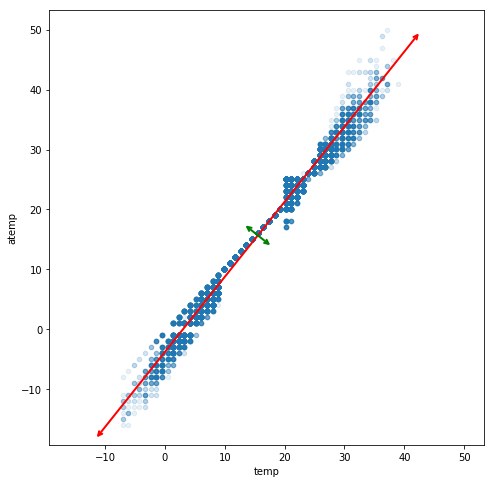

In [37]:
# Draw principal components on top of scatterplot
def draw_vector(v0, v1, ax, c='r'):
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0,
                    shrinkB=0,
                    color=c
                   )
    ax.annotate('', v1, v0, arrowprops=arrowprops)

fig, ax = plt.subplots(figsize=(8, 8))
bikes.plot(kind='scatter', x='temp', y='atemp', alpha=0.1, ax=ax)
for length, vector, color in zip(pca.explained_variance_, pca.components_, ['r', 'g']):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v, ax=ax, c=color)
    draw_vector(pca.mean_, pca.mean_ - v, ax=ax, c=color)
ax.set_aspect('equal')
ax.set_xlim(ax.get_ylim());

### Example: PCA on the Ames Dataset

In [38]:
X = ames_small.drop('SalePrice', axis='columns')
y = ames_small.loc[:, 'SalePrice']

If one feature is measured on a scale of 1-10 while another is on a scale of 1-1000, for instance, then PCA will tend to focus on capturing the feature that is on a scale of 1-1000. We want PCA to identify maximally informative combinations of features regardless of their scale, so it is generally a good idea to avoid this problem by standardizing features before applying PCA. Standardizing gives each feature a mean of 0 and a variance of 1 by substracting the feature mean and dividing by its standard deviation. 

In [39]:
# Apply `StandardScaler` to `X`
# /scrub/
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

/Users/gGandenberger/anaconda3/envs/ga/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/gGandenberger/anaconda3/envs/ga/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [40]:
# Confirm column means are 0 and variances are 1
# /scrub/
pd.DataFrame(X_scaled).agg(['mean', 'var'])

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
mean,7.244205e-17,6.661338e-18,-1.798561e-16,2.940981e-15,-2.081668e-17,-2.220446e-17,-4.884981e-17,3.441691e-17,5.939693e-17,2.707209e-16,...,9.572204e-17,9.325873e-17,4.440892e-18,-2.553513e-17,6.689094e-17,7.216450e-17,0.0,1.337819e-16,1.343370e-16,1.414424e-14
var,1.010101e+00,1.010101e+00,1.010101e+00,1.010101e+00,1.010101e+00,1.010101e+00,1.010101e+00,1.010101e+00,1.010101e+00,1.010101e+00,...,1.010101e+00,1.010101e+00,1.010101e+00,1.010101e+00,1.010101e+00,1.010101e+00,0.0,1.010101e+00,1.010101e+00,1.010101e+00


In [41]:
# Apply PCA to scaled features
# /scrub/
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [42]:
# Look at first two rows of PCA features
# /scrub/
X_pca[:2]

array([[-1.86180914e+00, -3.87741107e-01, -2.97344985e-01,
         2.32841742e+00,  1.73282870e+00, -2.64078474e+00,
         3.37003900e+00,  2.05824339e+00, -3.85007541e-01,
        -5.12464418e-01,  1.08032830e-01,  9.24938061e-01,
        -1.51765648e+00, -3.20790411e-01,  1.17517559e+00,
         4.61937473e-01, -1.23010658e+00, -4.49619962e-01,
         5.80680032e-01, -7.23856763e-01,  6.29181434e-02,
        -3.96753066e-01,  1.09038055e-01,  7.24436787e-01,
         8.24448308e-03, -9.79612554e-02,  7.88941917e-02,
         2.23635522e-01, -4.51053267e-02, -2.11315204e-16,
         4.93241499e-16, -1.19020247e-16],
       [ 4.55864936e+00,  1.08759329e+00, -5.80240374e-01,
         1.14589229e+00, -2.27018040e-01, -6.15968340e-02,
        -5.13353502e-01,  6.95275459e-01,  3.07295626e-01,
         1.00991871e+00,  3.80139135e-01, -1.06776006e+00,
         1.12313665e+00, -9.88538639e-01, -1.01572305e+00,
        -2.27396534e-01, -2.46736774e-01, -4.37429002e-01,
        -3.16

Trying to interpret these features is usually a fool's errand.

PCA has generated a set of features in order of decreasing variance. Variance tends to be associated with informativeness about the target, so we can use this ordering for feature selection.

In [43]:
# Get scores vs. number of PCA features
# /scrub/
def keep_feature_order(X, y):
    return X.columns

scores = my_cv_score_by_num_features(linreg, pd.DataFrame(X_pca), y, keep_feature_order)

100%|██████████| 10/10 [00:00<00:00, 11.84it/s]


In [44]:
# Occasionally things go badly wrong and we get a huge negative score;
# clip scores at 0 so that we can see what is going on in the other cases.
# /scrub/
scores.loc[:, 'test'] = scores.loc[:, 'test'].clip(0)

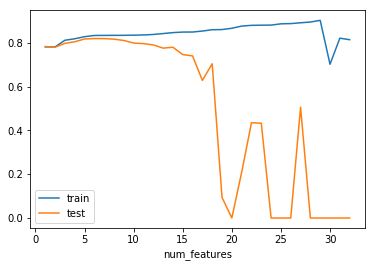

In [45]:
# Plot scores
# /scrub/
ax = scores.plot(x='num_features')

### PCA + Feature Selection Compared to Simple Feature Selection

PCA followed by feature selection preserves more of the variation in the feature matrix than feature selection alone. As a result, it often allows you to decrease variance with less of an increase in bias. However, this outcome is not guaranteed.

One downside of using PCA is that it typically makes your feature uninterpretable.

**Exercise (10 mins., in pairs)**

- Load the `glass` dataset from the file `glass.csv` in this lesson's `assets/data` directory into a Pandas DataFrame called `glass`.

In [46]:
# /scrub/
glass = pd.read_csv('../assets/data/glass.csv')

- Create a new column "household" that has the value `1` where "Type" is greater than 4 and zero elsewhere.

In [47]:
# /scrub/
glass.loc[:, 'household'] = (glass.loc[:, 'Type'] > 4).astype(int)

- Using "household" as your target variable, define a feature matrix `X` and target vector `y` for the `glass` dataset. (Do not use "Type" as a feature variable!)

In [48]:
# /scrub/
X = glass.drop(['Type', 'household'], axis='columns')

In [49]:
# /scrub/
y = glass.loc[:, 'household']

- Apply PCA to your feature matrix `X`, and call the result `X_pca`.

In [50]:
# /scrub/
pca = PCA()
X_pca = pca.fit_transform(X)

- Use our function `my_cv_score_by_num_features` to add principal components one at a time to a logistic regression model for the glass dataset and get the score at each stage.

In [51]:
# /scrub/
scores = my_cv_score_by_num_features(logreg, pd.DataFrame(X_pca), y, keep_feature_order)

100%|██████████| 10/10 [00:00<00:00, 36.64it/s]


- Clip and plot the scores

In [52]:
# /scrub/
scores.loc[:, 'test'] = scores.loc[:, 'test'].clip(0)

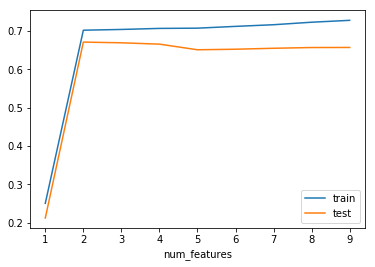

In [53]:
# /scrub/
ax = scores.plot(x='num_features')

- **Bonus:** Calculate scores without using `my_cv_score_by_num_features`, and plot them.

In [54]:
# /scrub/
rfc = RandomForestClassifier()

train_scores = []
test_scores = []

kf = KFold(n_splits=10, shuffle=True)
for train_rows, test_rows in tqdm(kf.split(X, y), total=10):
    X_train = X.iloc[train_rows, :]
    X_test = X.iloc[test_rows, :]
    y_train = y.iloc[train_rows]
    y_test = y.iloc[test_rows]

    ranked_features = X.columns

    train_scores_fold = []
    test_scores_fold = []
    for num_features in range(1, len(ranked_features) + 1):
        feature_cols = ranked_features[:num_features]
        X_train_k = X_train.loc[:, feature_cols]
        X_test_k = X_test.loc[:, feature_cols]

        linreg.fit(X_train_k, y_train)
        train_scores_fold.append(linreg.score(X_train_k, y_train))
        test_scores_fold.append(linreg.score(X_test_k, y_test))

    train_scores.append(train_scores_fold)
    test_scores.append(test_scores_fold)

train_scores = np.array(train_scores).T.mean(axis=1)
test_scores = np.array(test_scores).T.mean(axis=1)
scores = pd.DataFrame({'num_features': range(1, len(ranked_features) + 1),
                       'train': train_scores, 'test': test_scores
                      })

100%|██████████| 10/10 [00:00<00:00, 33.83it/s]


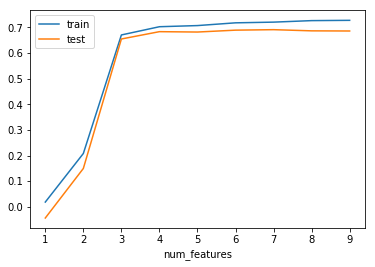

In [55]:
# /scrub/
scores.plot(x='num_features')

$\blacksquare$

## Regularization

Regularization makes your model pay a penalty to use the features, so that it will use them only to the extent that the benefit in terms of improving fit on the training set outweighs the penalty.

You can think of regularization as a **continuous generalization** of feature selection: it allows the model to rely on a given feature *less* than it would, without regularization without taking its use of that variable all the way to zero.

### Ridge Regression

#### Example: Ridge Regression on the Mammals Dataset

**Ridge regression** is linear regression with a twist: instead of minimizing mean squared error alone, it minimizes a weighted sum of the mean squared error and *the sum of the squares of the coefficients*.

The hyperparameter $\alpha$ controls how much weight is put on keeping the coefficients small vs. reducing MSE. **A larger value for $\alpha$ leads to more regularization.**.

In [56]:
mammals = pd.read_csv('../assets/data/mammals.txt', delimiter='\t', names=['brain', 'body'], header=1)

In [57]:
# Limit the scope of the model to mammals with body weights under 200 kg
# to make it easier to see what's going on.
# /scrub/
mammals = mammals.loc[mammals.loc[:, 'body'] <= 200, :]

In [58]:
# Create our feature matrix and target vector
# /scrub/
feature_cols = ['body']
target_col = 'brain'

X = mammals.loc[:, feature_cols]
y = mammals.loc[:, target_col]

In [59]:
# Get fifth-order polynomial features
# /scrub/
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(5, include_bias=False)
X_poly = pf.fit_transform(X)

/Users/gGandenberger/anaconda3/envs/ga/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.093553e-21
  overwrite_a=True).T
/Users/gGandenberger/anaconda3/envs/ga/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.901558e-19
  overwrite_a=True).T


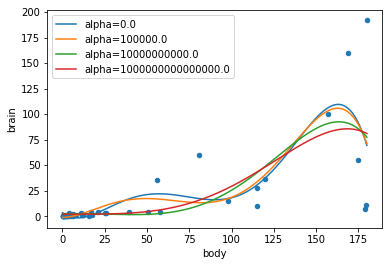

In [60]:
# Plot the fitted regression curve at four levels of alpha
# /scrub/
from sklearn.linear_model import Ridge

ax = mammals.plot(x='body', y='brain', kind='scatter')

for alpha in np.hstack([0, np.logspace(5, 15, 3)]):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_poly, y)
    x_grid = np.linspace(mammals.loc[:, 'body'].min(), mammals.loc[:, 'body'].max(), 200).reshape(-1, 1)
    X_grid_poly = pf.fit_transform(x_grid)
    y_pred = ridge.predict(X_grid_poly)
    ax.plot(x_grid, y_pred, label=f'alpha={alpha}')

ax.legend();

Ridge regression minimizes $SSE + \alpha \sum{\beta_i^2}$, where $SSE$ is the sum of squared errors.

Setting $\alpha=0$ causes Ridge regression to minimize $SSE$ only, reducing it to standard linear regression.

Increasing $\alpha$ increases the penalty for large coefficients, which nudges the model toward simpler, flatter shapes.

**Exercise (1 min.)**

- How does increase $\alpha$ affect bias and variance?

Increases bias, decreases variance.

#### Example: Ridge Regression on the Ames Dataset

Let's apply Ridge regression to the Ames dataset.

In [61]:
X = ames_df_num.drop('SalePrice', axis='columns')
y = ames_df.loc[:, 'SalePrice']

It's generally a good idea to standardize features before applying regularization; otherwise the effects of regularization will depend on feature scale.

In [62]:
# Use Ridge regression to reduce overfitting
# /scrub/

print(my_cv_score(linreg, X, y))
      
ridge = Ridge(alpha=500)
X_scaled = scaler.fit_transform(X)
print(my_cv_score(ridge, X_scaled, y))

(0.7788559155673486, 0.7307411610581306)
(0.7663538653157506, 0.7385967034892499)


/Users/gGandenberger/anaconda3/envs/ga/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/gGandenberger/anaconda3/envs/ga/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [63]:
# Measure training-set and test performance at different levels of alpha
# /scrub/
X_scale = scaler.fit_transform(X)
scores = [(alpha, *my_cv_score(Ridge(alpha=alpha), X_scale, y))
          for alpha in tqdm(np.linspace(1, 2001, 201))]

/Users/gGandenberger/anaconda3/envs/ga/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/gGandenberger/anaconda3/envs/ga/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
100%|██████████| 201/201 [00:03<00:00, 57.63it/s]


In [64]:
# Put scores into a DataFrame
# /scrub/
scores_df = pd.DataFrame(scores, columns=['alpha', 'train', 'test'])
scores_df.head()

,alpha,train,test
0,1.0,0.778856,0.730847
1,11.0,0.778820,0.731823
2,21.0,0.778735,0.732671
3,31.0,0.778611,0.733413
4,41.0,0.778456,0.734066


As we increase $\alpha$, training-set performance will decrease but test-set performance will often increase, then decrease.

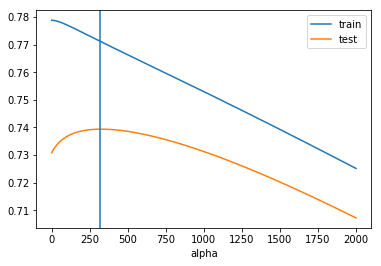

In [65]:
# Plot scores, with a vertical line at the best alpha
# /scrub/
ax = scores_df.plot(x='alpha')
ax.axvline(scores_df.loc[scores_df.loc[:, 'test'].idxmax(), 'alpha']);

We can see how increasing $\alpha$ causes Ridge regression to choose smaller coefficient values.

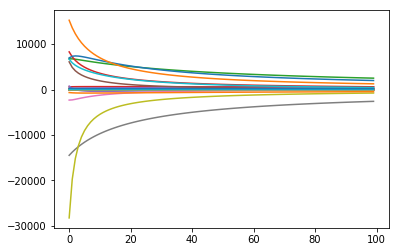

In [66]:
# Plot Ridge coefficients against alpha 
# /scrub/
coefs = [Ridge(alpha=alpha).fit(X, y).coef_ for alpha in np.linspace(1, 2000, 100)]
coefs_df = pd.DataFrame(coefs)
coefs_df.plot(legend=False);

### Lasso Regression

Lasso regression is similar to Ridge regression, but it uses the sum of the absolute values of the coefficients as its penalty term instead of the sum of squares.

One consequence of this difference is that Lasson regression will take coefficients all the way to zero, while Ridge regression will not.

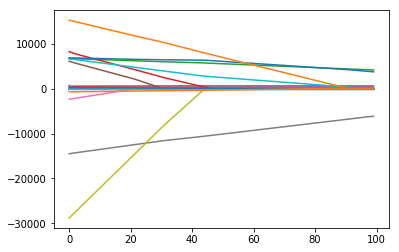

In [67]:
# Plot Lasso coefficients against alpha 
# /scrub/
from sklearn.linear_model import Lasso

coefs = [Lasso(alpha=alpha).fit(X, y).coef_ for alpha in np.linspace(1, 2000, 100)]
coefs_df = pd.DataFrame(coefs)
coefs_df.plot(legend=False);

Lasso minimizes $SSE + \alpha \sum{|\beta_i|}$, where $SSE$ is the sum of squared errors.

Using squared coefficients as a penalty term as in Ridge regression is called **$L_2$ regularization**, while using absolute values of coefficients as in Lasso is called **$L_1$ regularization**.

### Ridge or Lasso?

If you only care about predictive accuracy, you can try both Lasso and Ridge regression and see which one works better.

If you also prefer a model that is easier to interpret and maintain, then the fact that Lasso drops variables is a point in its favor.

There is also an **[elastic net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)** algorithm that uses both $L_1$ and $L_2$ penalties.

**Exercise (6 mins., in pairs)**

- Measure training-set and test-set performance at various levels of alpha between 0 and 5000 for Lasso regression on the Ames housing dataset features we used above. Set `max_iter=10_000` when you instantiage the Lasso class to ensure that the algorithm converges.

In [68]:
# /scrub/
X_scale = scaler.fit_transform(X)
scores = [(alpha, *my_cv_score(Lasso(alpha=alpha, max_iter=10_000), X_scale, y))
          for alpha in tqdm(np.linspace(1, 5001, 201))]

/Users/gGandenberger/anaconda3/envs/ga/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/gGandenberger/anaconda3/envs/ga/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
100%|██████████| 201/201 [00:06<00:00, 32.03it/s]


- Plot those scores as a function of $\alpha$, with a vertical line indicating the best value for $\alpha$.

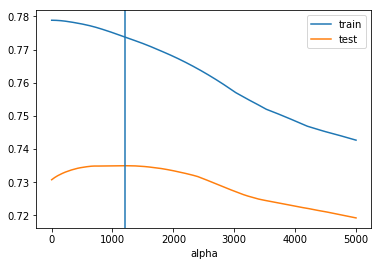

In [69]:
# /scrub/
scores_df = pd.DataFrame(scores, columns=['alpha', 'train', 'test'])
ax = scores_df.plot(x='alpha')
ax.axvline(scores_df.loc[scores_df.loc[:, 'test'].idxmax(), 'alpha'])

- What value for $\alpha$ gave the best results?

In [70]:
# /scrub/
scores_df.loc[scores_df.loc[:, 'test'].idxmax(), 'alpha']

1201.0

$\blacksquare$

$L_1$ and $L_2$ regularization can also be used with other models than linear regression. For instance, scikit-learn supports them for [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), and [XGBoost](https://xgboost.readthedocs.io/en/latest/) incorporates them into decision tree ensembling.

## Summary

- The surest way to address overfitting is to get more data. When getting more data is not an option, you can try feature selection, dimensionality reduction, and regularization.
- Feature selection can yield good predictive performance, is easy to understand, and yields simpler models.
- Dimensionality reduction, for instance with PCA, can yield better predictive performance by giving the model more information to work with at a given degree of complexity. However, it is harder to understand and typically yields uninterpretable models.
- Regularization can be thought of as a continuous generalization of feature selection: it nudges all coefficients toward zero rather than setting some of them fully to zero without affecting the others. It can drop some variables entirely when used with an $L_1$ penalty, but not with an $L_2$ penalty.